In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog


In [13]:

def image_display(image,title=''):
    plt.title(title)
    plt.imshow(image, cmap='Greys_r')
    plt.show()
    
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    if conv == 'HSV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    if color_space == 'HLS':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    if color_space == 'YUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    if color_space == 'BGR':
        return cv2.cvtColor(img, cv2.COLOR_RGB2BGR)


In [14]:
# Read in cars and notcars
car_images ={}
car_images['far'] = glob.glob('vehicles/GTI_Far/*.png')
car_images['left'] = glob.glob('vehicles/GTI_Left/*.png')
car_images['middle_close'] = glob.glob('vehicles/GTI_MiddleClose/*.png')
car_images['right'] = glob.glob('vehicles/GTI_Right/*.png')
car_images['extracted'] = glob.glob('vehicles/KITTI_extracted/*.png')

not_car_images={}
not_car_images['gti'] = glob.glob('non-vehicles/GTI/*.png')
not_car_images['extra'] = glob.glob('non-vehicles/Extras/*.png')

train_cars = []
test_cars = []
train_not_cars = []
test_not_cars = []
split_percent = 0.8
for key,image_list in car_images.items():
    split = int(len(image_list)*split_percent)
    train_cars.extend(image_list[:split])
    test_cars.extend(image_list[split:])
for key,image_list in not_car_images.items():
    split = int(len(image_list)*split_percent)
    train_not_cars.extend(image_list[:split])
    test_not_cars.extend(image_list[split:])

print(' ---------------------------------------------')
print('|Train samples | cars: {} | not_cars: {}  |'.format(len(train_cars), len(train_not_cars)))
print('|---------------------------------------------|')
print('|Test samples  | cars: {} | not_cars: {}  |'.format(len(test_cars), len(test_not_cars)))
print(' ---------------------------------------------')

 ---------------------------------------------
|Train samples | cars: 7032 | not_cars: 7174  |
|---------------------------------------------|
|Test samples  | cars: 1760 | not_cars: 1794  |
 ---------------------------------------------


In [19]:
import matplotlib.image as mpimg
import numpy as np
import cv2
from skimage.feature import hog


# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features


def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))
                        
def color_hist(img, nbins=32):    #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

def extract_features(image, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    file_features = []
    file_features_mirror = []
    
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(image)      

    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        file_features.append(spatial_features)
    if hist_feat == True:
        # Apply color_hist()
        hist_features = color_hist(feature_image, nbins=hist_bins)
        file_features.append(hist_features)
    if hog_feat == True:
    # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        file_features.append(hog_features)
    return file_features


# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def process_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True, extra=False):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        file_features_mirror = []
        # Read in each one by one
        image = mpimg.imread(file)
        file_features = extract_features(image, color_space, spatial_size,
                        hist_bins, orient, 
                        pix_per_cell, cell_per_block, hog_channel,
                        spatial_feat, hist_feat, hog_feat)
        
        # apply color conversion if other than 'RGB'
        features.append(np.concatenate(file_features))
        
        if extra:
            flipped_image = np.fliplr(image)
            file_features_mirror = extract_features(flipped_image, color_space, spatial_size,
                            hist_bins, orient, 
                            pix_per_cell, cell_per_block, hog_channel,
                            spatial_feat, hist_feat, hog_feat)
            features.append(np.concatenate(file_features_mirror))
        
        
    # Return list of feature vectors
    return features
    


#stanrdize test & train sets
def gather_features(train_cars,test_cars,train_not_cars,test_not_cars):
    train_car_features = process_features(train_cars, color_space=color_space,
                        spatial_size=spatial_size, hist_bins=hist_bins,
                        orient=orient, pix_per_cell=pix_per_cell,
                        cell_per_block=cell_per_block,
                        hog_channel=hog_channel, spatial_feat=spatial_feat,
                        hist_feat=hist_feat, hog_feat=hog_feat, extra=True)
    test_car_features = process_features(test_cars, color_space=color_space,
                            spatial_size=spatial_size, hist_bins=hist_bins,
                            orient=orient, pix_per_cell=pix_per_cell,
                            cell_per_block=cell_per_block,
                            hog_channel=hog_channel, spatial_feat=spatial_feat,
                            hist_feat=hist_feat, hog_feat=hog_feat)
    train_notcar_features = process_features(train_not_cars, color_space=color_space,
                            spatial_size=spatial_size, hist_bins=hist_bins,
                            orient=orient, pix_per_cell=pix_per_cell,
                            cell_per_block=cell_per_block,
                            hog_channel=hog_channel, spatial_feat=spatial_feat,
                            hist_feat=hist_feat, hog_feat=hog_feat,extra=True)
    test_notcar_features = process_features(test_not_cars, color_space=color_space,
                            spatial_size=spatial_size, hist_bins=hist_bins,
                            orient=orient, pix_per_cell=pix_per_cell,
                            cell_per_block=cell_per_block,
                            hog_channel=hog_channel, spatial_feat=spatial_feat,
                            hist_feat=hist_feat, hog_feat=hog_feat)

    train_len = len(train_car_features)+len(train_notcar_features)
    # Standardizing all x
    X = np.vstack((train_car_features, train_notcar_features,test_car_features, test_notcar_features)).astype(np.float64)
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    x_all = X_scaler.transform(X)
    X_train = x_all[:train_len]
    X_test = x_all[train_len:]

    # Define the labels vector
    y_train = np.hstack((np.ones(len(train_car_features)), np.zeros(len(train_notcar_features))))
    y_test = np.hstack((np.ones(len(test_car_features)), np.zeros(len(test_notcar_features))))

    print(' -----------------------------------------')
    print('|Train set | X_train:{} y_train:{}  |'.format(len(X_train), len(y_train)))
    print('|-----------------------------------------|')
    print('|Test set  | X_test: {} y_test:{}     |'.format(len(X_test), len(y_test)))
    print(' -----------------------------------------')

    return X_train,X_test,y_train,y_test, X_scaler


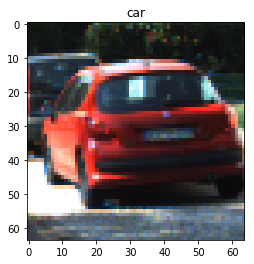

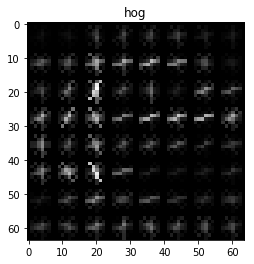

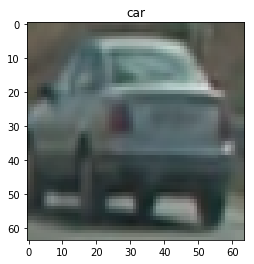

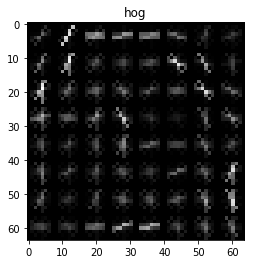

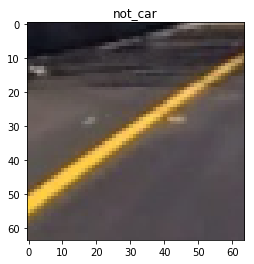

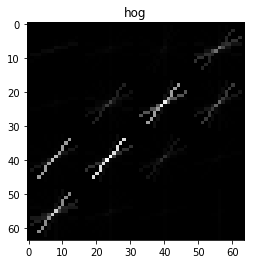

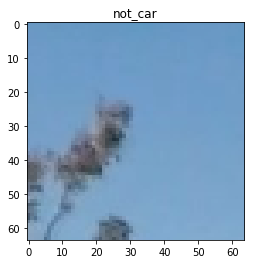

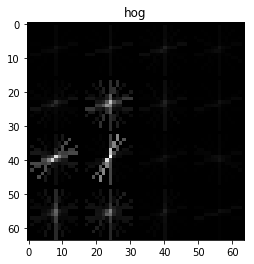

In [20]:
sample_car = mpimg.imread('vehicles/KITTI_extracted/305.png')
gray_car = cv2.cvtColor(sample_car, cv2.COLOR_RGB2YCrCb)[:,:,2]
_, im_car_hog = get_hog_features(gray_car, 9,8, 2, vis=True, feature_vec=True)
image_display(sample_car, 'car')
image_display(im_car_hog, 'hog')

sample_car = mpimg.imread('vehicles/GTI_Right/image0038.png')
gray_car = cv2.cvtColor(sample_car, cv2.COLOR_RGB2YCrCb)[:,:,2]
_, im_car_hog = get_hog_features(gray_car, 9,8, 2, vis=True, feature_vec=True)
image_display(sample_car, 'car')
image_display(im_car_hog, 'hog')

sample_not_car = mpimg.imread('non-vehicles/Extras/extra27.png')
gray_not_car = cv2.cvtColor(sample_not_car, cv2.COLOR_RGB2YCrCb)[:,:,2]
_, im_not_car_hog = get_hog_features(gray_not_car, 9,16, 1, vis=True, feature_vec=True)
image_display(sample_not_car, 'not_car')
image_display(im_not_car_hog, 'hog')


sample_not_car = mpimg.imread('non-vehicles/Extras/extra30.png')
gray_not_car = cv2.cvtColor(sample_not_car, cv2.COLOR_RGB2YCrCb)[:,:,2]
_, im_not_car_hog = get_hog_features(gray_not_car, 9,16, 1, vis=True, feature_vec=True)
image_display(sample_not_car, 'not_car')
image_display(im_not_car_hog, 'hog')

In [21]:

# Parameters 
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
# y_start_stop = [None, None] # Min and max in y to search in slide_window()

X_train, X_test, y_train, y_test, X_scaler = gather_features(train_cars,test_cars,train_not_cars,test_not_cars)

print(' -----------------------------------------')
print('|Train set | X_train:{} y_train:{}  |'.format(len(X_train), len(y_train)))
print('|-----------------------------------------|')
print('|Test set  | X_test: {} y_test:{}     |'.format(len(X_test), len(y_test)))
print(' -----------------------------------------')


 -----------------------------------------
|Train set | X_train:28412 y_train:28412  |
|-----------------------------------------|
|Test set  | X_test: 3554 y_test:3554     |
 -----------------------------------------
 -----------------------------------------
|Train set | X_train:28412 y_train:28412  |
|-----------------------------------------|
|Test set  | X_test: 3554 y_test:3554     |
 -----------------------------------------


In [23]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
# Check the training time for the SVC
t=time.time()

svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Accuracy of SVC {}'.format(round(svc.score(X_test, y_test), 4)))
# Check the prediction time for a single sample
t=time.time()
n_predict = 100
t2 = time.time()
print('Took {} Seconds to predict{} samples'.format(round(t2-t, 5),  n_predict))



Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 8460
37.91 Seconds to train SVC...
Accuracy of SVC 0.9899
Took 5e-05 Seconds to predict100 samples


In [24]:
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,color_space):
    boxes= []
    
    draw_img = np.copy(img)
    
    img_tosearch = img[ystart:ystop,:,:]
    if color_space != 'RGB':
        ctrans_tosearch = convert_color(img_tosearch, conv=color_space)
    else:
        ctrans_tosearch = np.copy(img_tosearch)

    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
    
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]
    
    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1, im1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block,vis=True, feature_vec=False)
    hog2, im2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block,vis=True, feature_vec=False)
    hog3,im3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block,vis=True, feature_vec=False)

    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
            
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                boxes.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
    return boxes
      

In [25]:

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

In [26]:
def adjust_gamma(image, gamma=1.0):
    ''' 
    build a lookup table mapping the pixel values [0, 255] to
    their adjusted gamma values
    '''
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255 for i in np.arange(0, 256)]).astype("uint8")

    # apply gamma correction using the lookup table
    return cv2.LUT(image, table)    


In [27]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2
from scipy.ndimage.measurements import label

class Vehicle():
    def __init__(self, center=None, bbox=None):
        self.center=center
        self.count_appeared = 0
        self.old_count_appeared = -1
        self.bbox = bbox
        self.not_updating=0
        
    def covers_range(self,new_point):
        offset = 25
        if self.center != None and \
            (new_point[0] >= self.center[0]-offset and  new_point[0] <=self.center[0]+offset or \
            new_point[1] >= self.center[1]-offset and  new_point[1] <=self.center[1]+offset):
            return True
        return False
    
    def covers_range2(self,new_point):
        offset = 0
        if self.bbox != None and \
            (new_point[0][0] >= self.bbox[0][0]-offset and  new_point[0][0] <=self.bbox[1][0]+offset and\
             new_point[1][0] >= self.bbox[0][0]-offset and  new_point[1][0] <=self.bbox[1][0]+offset) and\
            (new_point[0][1] >= self.bbox[0][1]-offset and  new_point[0][1] <=self.bbox[1][1]+offset and\
             new_point[1][1] >= self.bbox[0][1]-offset and  new_point[1][1] <=self.bbox[1][1]+offset):
            return True
        elif(self.bbox[0][0] >= new_point[0][0]-offset and  self.bbox[0][0] <=new_point[1][0]+offset and\
             self.bbox[1][0] >= new_point[0][0]-offset and  self.bbox[1][0] <=new_point[1][0]+offset) and\
            (self.bbox[0][1] >= new_point[0][1]-offset and  self.bbox[0][1]<=new_point[1][1]+offset and\
             self.bbox[1][1] >= new_point[0][1]-offset and  self.bbox[1][1]<=new_point[1][1]+offset):
            return True
        return False
    
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap < threshold] = 0
    return heatmap

def draw_labeled_bboxes(img, labels, vehicles,not_sequence):
    centers={}
    good_vehicles=[]
    new_vehicles = []      
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        
        center = (np.mean([bbox[0][0], bbox[0][1]]), np.mean([bbox[1][0], bbox[1][1]]))
        centers[car_number]=center
        in_range = False
        
        if not_sequence is False:
            if len(vehicles) >0:
                for vehicle in vehicles:
                    if vehicle.covers_range2(bbox) or vehicle.covers_range(center):
                        vehicle.count_appeared +=1

                        new_bbox=((np.int(np.mean([bbox[0][0],vehicle.bbox[0][0],vehicle.bbox[0][0]])), np.int(np.mean([bbox[0][1], vehicle.bbox[0][1],vehicle.bbox[0][1]]))),\
                                  (np.int(np.mean([bbox[1][0],vehicle.bbox[1][0],vehicle.bbox[1][0]])),np.int(np.mean([bbox[1][1], vehicle.bbox[1][1],vehicle.bbox[1][1]]))))
                        vehicle.bbox= new_bbox
                        vehicle.center =(np.mean([new_bbox[0][0], new_bbox[0][1]]), np.mean([new_bbox[1][0], new_bbox[1][1]]))

                        in_range= True
                        break

            if in_range is False:
                new_vehicle = Vehicle(center,bbox)
                new_vehicles.append(new_vehicle)
        else:
            new_vehicle = Vehicle(center,bbox)
            new_vehicles.append(new_vehicle) 
        
        
    #filter bad vehicles except the 
    if not_sequence is False:
        if len(vehicles) > 0:
            for i in range(len(vehicles)): 
                if vehicles[i].old_count_appeared ==  vehicles[i].count_appeared:
                    if vehicles[i].not_updating >1:
                        if vehicles[i].count_appeared>1:
                            vehicles[i].count_appeared-=2
                            vehicles[i].old_count_appeared-=2
                            good_vehicles.append(vehicles[i])
                        else:
                            pass
                    elif vehicles[i].not_updating ==1 and vehicles[i].old_count_appeared ==0:
                        pass
                    else:
                        #candidate
                        vehicles[i].not_updating+=1
                        good_vehicles.append(vehicles[i])
                elif vehicles[i].old_count_appeared <  vehicles[i].count_appeared:
                    vehicles[i].not_updating= 0
                    good_vehicles.append(vehicles[i])
                else:
                    pass
 
    #add 
    good_vehicles.extend(new_vehicles)
    for vehicle in good_vehicles:
        if not_sequence is False:
            if vehicle.count_appeared ==0 and vehicle.old_count_appeared ==0 and vehicle.not_updating>0:
                pass
            else:
                if vehicle.old_count_appeared >-1:
                    cv2.rectangle(img, vehicle.bbox[0],vehicle.bbox[1], (255,0,0), 6)
        else:
            cv2.rectangle(img, vehicle.bbox[0],vehicle.bbox[1], (255,0,0), 6)

    # Return the image
    return img, centers, good_vehicles


In [33]:
def pipeline(image):
    global vehicles
    global not_sequence
    
    draw_image = np.copy(image)
    heat = np.zeros_like(image[:,:,0]).astype(np.float)

    im = np.copy(draw_image)
    # Uncomment the following line if you extracted training
    # data from .png images (scaled 0 to 1 by mpimg) and the
    # image you are searching is a .jpg (scaled 0 to 255)
    im = im.astype(np.float32)/255
    
    ystart = 400
    ystop = 656

    scale = 1.5
    #'RGB2YCrCb' , 'BGR2YCrCb' , 'LUV', 'HSV', 'HLS', 'YUV':
    color_space = 'RGB2YCrCb'
    bboxes = find_cars(im, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, color_space)
    heat = add_heat(heat,bboxes)
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,1)
    
    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)
    
    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    
    draw_img,centers, vehicles = draw_labeled_bboxes(np.copy(image), labels, vehicles,not_sequence)
    i =0
#     font = cv2.FONT_HERSHEY_SIMPLEX
#     for vehicle in vehicles:
#         cv2.putText(draw_img,'{} : {} ,{}'.format(vehicle.center,vehicle.count_appeared,vehicle.old_count_appeared),(850,50+i), font, 1,(255,255,255),2)
#         i+=50
#         vehicle.old_count_appeared=vehicle.count_appeared

    if not_sequence is True:
        fig = plt.figure()
        plt.imshow(heatmap, cmap='hot')
        plt.title('Heat Map')
        plt.show()
    return draw_img

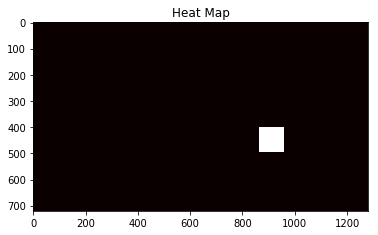

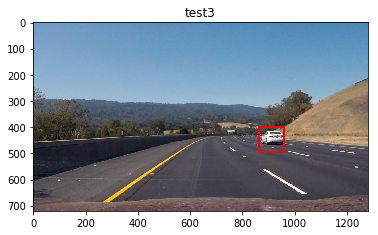

....................................


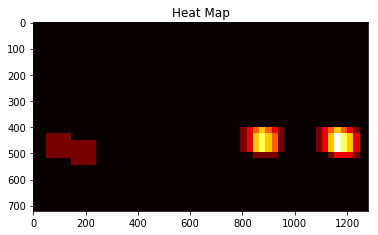

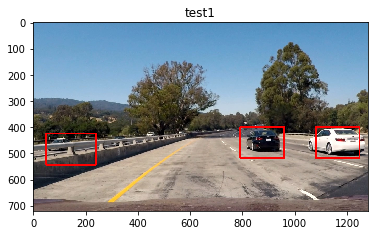

....................................


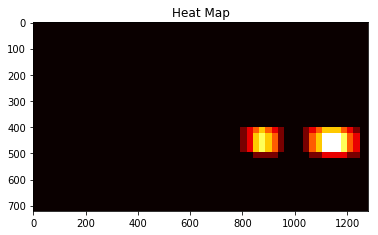

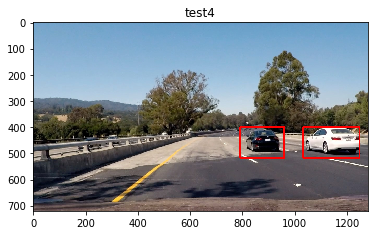

....................................


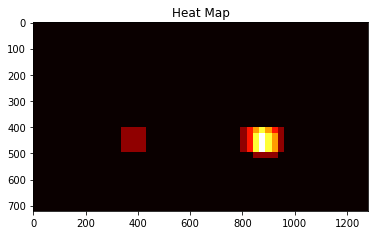

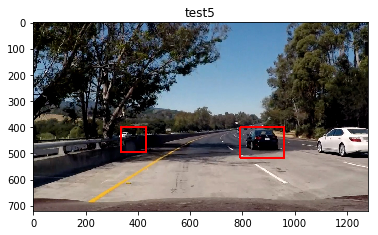

....................................


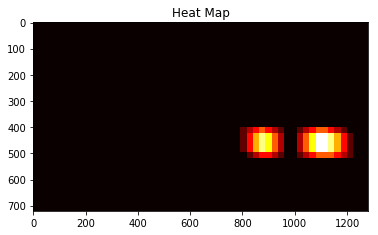

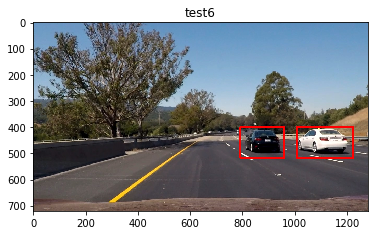

done


In [35]:
vehicles = []
not_sequence = True
o1= pipeline(mpimg.imread('test_images/test3.jpg'))
image_display(o1,'test3')
print('....................................')
o1=pipeline(mpimg.imread('test_images/test1.jpg'))
image_display(o1, 'test1')
print('....................................')
# o1=pipeline(mpimg.imread('test_images/test2.jpg'))
# image_display(o1,'test2')
o1=pipeline(mpimg.imread('test_images/test4.jpg'))
image_display(o1,'test4')
print('....................................')
o1=pipeline(mpimg.imread('test_images/test5.jpg'))
image_display(o1,'test5')
print('....................................')
o1=pipeline(mpimg.imread('test_images/test6.jpg'))
image_display(o1,'test6')

print('done')

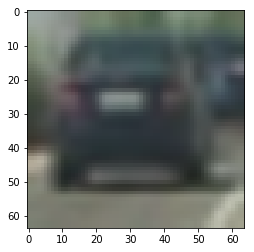

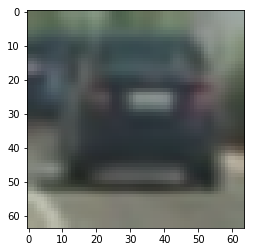

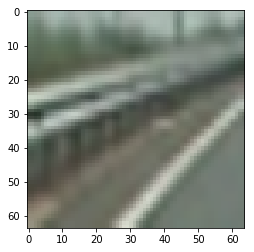

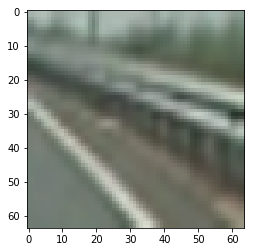

In [34]:
image = mpimg.imread('vehicles/GTI_Far/image0000.png')
image_display(image)
flipped_image = np.fliplr(image)
image_display(flipped_image)

image = mpimg.imread('non-vehicles/GTI/image8.png')
image_display(image)
flipped_image = np.fliplr(image)
image_display(flipped_image)


In [31]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
vehicles = []
not_sequence = False
video_output = 'project_output.mp4'
clip = VideoFileClip('project_video.mp4')
project_clip = clip.fl_image(pipeline)
%time project_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video project_output.mp4
[MoviePy] Writing video project_output.mp4


100%|█████████▉| 1260/1261 [38:37<00:02,  2.69s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_output.mp4 

CPU times: user 37min 6s, sys: 51 s, total: 37min 57s
Wall time: 38min 38s


In [32]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))

In [ ]:
vehicles = []
not_sequence = False
video_output2 = 'project_combined_output.mp4'
clip = VideoFileClip('project_video_old.mp4')
project_clip = clip.fl_image(pipeline)
%time project_clip.write_videofile(video_output2, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output2))